# Load the data

In [1]:
# Mount Google Drive locally
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

df = pd.read_pickle("/content/drive/MyDrive/liveproject/mortgage_data_preprocessed.pkl.gz")

# Install AIF360

In [3]:
# install AIF360
!pip install aif360

     |████████████████████████████████| 184kB 9.6MB/s 
     |████████████████████████████████| 358kB 14.6MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491627 sha256=881d1b8e34c26b18d1f11e1a646f4d04572f7686f25be8a6695973e6399f3aee
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-cp37-none-any.whl size=30180 sha256=05ad822b34433970d02dc2f6f1d9049b20ea26258cc62ad7c526b9843e1f6ad6
  Stored in directory: /root/.cache/pip/wheels/02/e4/0b/aaab481fc5dd2a4ea59e78bc7231bb6aae7635ca7ee79f8ae5
Successfully built shap memory-profiler


# Train a classifier, implement post-processing, and compute metrics

In [5]:
# Instantiate the classifier
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=10, solver="lbfgs", penalty="none")

# instantiate the cross-validation scheme
from sklearn.model_selection import StratifiedKFold
mv = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

# setup the performance metrics to be computed
from sklearn import metrics
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score,
                "AUC": metrics.roc_auc_score, 
                "F1-Score": metrics.f1_score, 
                }

# Set up the fairness metrics to be computed using AIF360
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

privileged_group = [{'applicant_sex_name_Female': 0}] 
unprivileged_group = [{'applicant_sex_name_Female': 1}]

In [7]:
from aif360.algorithms.postprocessing import EqOddsPostprocessing

# Learn parameters to equalize odds and apply to create a new dataset
epp = EqOddsPostprocessing(privileged_groups = privileged_group,
                                     unprivileged_groups = unprivileged_group,
                                     seed=42)


In [8]:
# Train a logistic regression classifier on the dataset and calculate metrics

import pandas as pd
import numpy as np
k, i = True, 1

# instantiating X
X = df.drop(labels=df.columns[-1], axis=1)

# instantiating the target variable
y = df[df.columns[-1]]

for (train, test) in mv.split(X, y):
    X_train = X.iloc[train].copy()
    y_train = y.iloc[train.copy()]
    # fit model
    lr = lr.fit(X_train, y_train.values.ravel())
   
    # get predictions in the test set
    X_test = X.iloc[test].copy()
    y_test = y.iloc[test].copy()
    ypred_prob = lr.predict_proba(X.iloc[test]).ravel()[1::2] # get probabilities
    ypred_class = lr.predict(X.iloc[test])

    # fit post-processing using results from 60% of the test set
    test_pct = 0.4
    n = int(len(y_test))
    n_2 = int(n* (1-test_pct))
    indices = np.random.permutation(n)
    pp_indices = indices[:n_2]
    test_indices = indices[n_2:]

    pp_dataset = X_test.iloc[pp_indices].copy()
    pp_dataset[df.columns[-1]] = np.expand_dims(y_test.iloc[pp_indices], axis=1)
    pp_dataset_BLD = BinaryLabelDataset(df=pp_dataset, label_names=['action_taken_name'], protected_attribute_names=['applicant_sex_name_Female'])

    pp_pred = X_test.iloc[pp_indices].copy()
    pp_pred[df.columns[-1]] = np.expand_dims(ypred_class[pp_indices], axis=1)
    pp_pred_BLD = BinaryLabelDataset(df=pp_pred, label_names=[df.columns[-1]], protected_attribute_names=['applicant_sex_name_Female'])

    epp = epp.fit(pp_dataset_BLD, pp_pred_BLD)

    # Use epp to post-process predictions on the other 40% of the test set
    actuals_test = X_test.iloc[test_indices].copy()
    actuals_test[df.columns[-1]] = np.expand_dims(y_test.iloc[test_indices], axis=1)
    actuals_test_BLD = BinaryLabelDataset(df=actuals_test, label_names=['action_taken_name'], protected_attribute_names=['applicant_sex_name_Female'])
    pred_test = X_test.iloc[test_indices].copy()
    pred_test[df.columns[-1]] = np.expand_dims(ypred_class[test_indices], axis=1)
    pred_test_BLD = BinaryLabelDataset(df=pred_test, label_names=[df.columns[-1]], protected_attribute_names=['applicant_sex_name_Female'])

    transf_pred_test_BLD = epp.predict(pred_test_BLD)

    # compute performance metrics
    metrics = []
    metric_CM = ClassificationMetric(actuals_test_BLD, transf_pred_test_BLD, privileged_groups=privileged_group, unprivileged_groups=unprivileged_group)
    for pf in perf_metrics.keys():
        if pf in ["AUC", "Brier"]:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_prob)]]
        else:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)]]
    
    # Compute fairness metrics
    metrics += [['Statistical Parity Difference', metric_CM.statistical_parity_difference()]]
    metrics += [['Disparate Impact', metric_CM.disparate_impact()]]
    metrics += [['Equal Opportunity Difference', metric_CM.equal_opportunity_difference()]]
    metrics += [['Average Odds Difference', metric_CM.average_odds_difference()]]
    metrics += [['Accuracy Male', metric_CM.accuracy(privileged=True)]]
    metrics += [['Accuracy Female', metric_CM.accuracy(privileged=False)]]


    # concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics = df_m.copy()
        k=0
    else:
        df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Creating an 

# Display the metrics in a table

In [9]:
# Display metrics
metrics_table = df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
metrics_table

,mean,std
,Value,Value
Metric,,
AUC,0.788912,0.003287
Accuracy,0.692010,0.004075
Accuracy Female,0.655413,0.011658
Accuracy Male,0.649417,0.010135
Average Odds Difference,0.000364,0.016273
Disparate Impact,1.075597,0.030932
Equal Opportunity Difference,0.004302,0.020170
F1-Score,0.634033,0.006775


# Chart the metrics

In [10]:
# Construct a DataFrame with allowable thresholds for plotting

fairness_df = pd.DataFrame(columns=["Metric", "Value", "Min", "Max"])
fairness_df.loc[0] = ['Disparate Impact'] + list((metrics_table[('mean', 'Value')]['Disparate Impact'], 0.8, 1.2))
fairness_df.loc[1] = ['Statistical Parity Difference'] + list((metrics_table[('mean', 'Value')]['Statistical Parity Difference'], -0.1, 0.1))
fairness_df.loc[2] = ['Average Odds Difference'] + list((metrics_table[('mean', 'Value')]['Average Odds Difference'], -0.1, 0.1))
fairness_df.loc[3] = ['Equal Opportunity Difference'] + list((metrics_table[('mean', 'Value')]['Equal Opportunity Difference'], -0.1, 0.1))

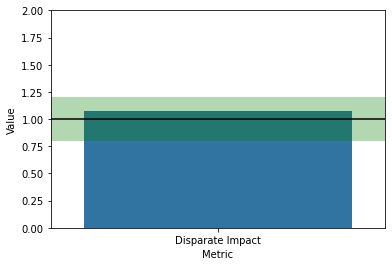

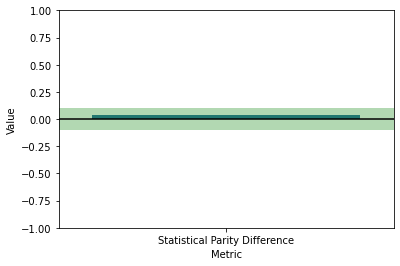

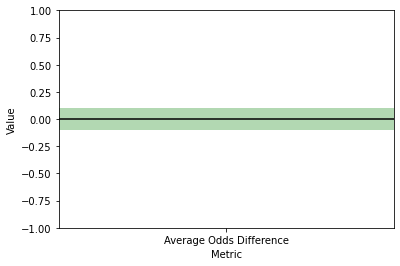

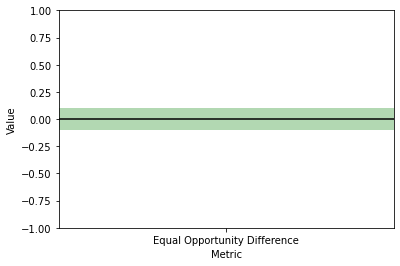

In [11]:
# Chart the metrics

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import numpy as np

def plot_metrics(df_fair): 
  def plot_metric(metric, ylim):
    fig, ax = plt.subplots()
    ax = sns.barplot(data=metric, x="Metric", y="Value")
    plt.axhline(np.mean(metric[["Min", "Max"]].values), color='black')
    plt.ylim(*ylim)
    range_height = metric[["Max"]].values[0][0] - metric[["Min"]].values[0][0]
    ax.add_patch(patches.Rectangle((-1, metric[["Min"]].values[0][0]), 2 , range_height, facecolor="green", alpha=0.3))

  plot_metric(df_fair.iloc[[0]], (0, 2))
  plot_metric(df_fair.iloc[[1]], (-1, 1))
  plot_metric(df_fair.iloc[[2]], (-1, 1))
  plot_metric(df_fair.iloc[[3]], (-1, 1))

plot_metrics(fairness_df)